In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# Read into csv file
schools_csv_file = "./Resources/dv279-schoollocations2019.csv"
schools_df = pd.read_csv(schools_csv_file)

In [3]:
# Drop unwanted columns
to_drop = ["School_Status",
          "Address_Line_1",
          "Address_Line_2",
          "Address_Town",
          "Address_State",
          "Postal_Address_Line_2",
          "Full_Phone_No",
          "Address_Postcode",
          "Postal_State"]

schools_df.drop(columns=to_drop, inplace=True)

# Split LGA Name
schools_df["LGA_Name"] = schools_df.LGA_Name.apply(lambda x: pd.Series(str(x).split(" "))) 

# Capitalise and lower postal town names
schools_df["Postal_Town"] = schools_df.Postal_Town.apply(lambda x: pd.Series(str(x).lower().title()))

# Rename postcode column
schools_df = schools_df.rename(columns={"Postal_Postcode": "Postcode",
                                       "Postal_Town": "Suburb",
                                       "X": "Lat",
                                       "Y": "Lng"})

schools_df.head()

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Postal_Address_Line_1,Suburb,Postcode,LGA_ID,LGA_Name,Lat,Lng
0,Government,1,1,Alberton Primary School,Primary,21 Thomson Street,Alberton,3971,681,Wellington,146.666601,-38.617713
1,Government,1,3,Allansford and District Primary School,Primary,Frank Street,Allansford,3277,673,Warrnambool,142.590393,-38.386281
2,Government,1,4,Avoca Primary School,Primary,P O Box 12,Avoca,3467,599,Pyrenees,143.475649,-37.084502
3,Government,1,8,Avenel Primary School,Primary,40 Anderson Street,Avenel,3664,643,Strathbogie,145.234722,-36.901368
4,Government,1,12,Warrandyte Primary School,Primary,5-11 Forbes Street,Warrandyte,3113,421,Manningham,145.213980,-37.742675


In [4]:
# Retrieve postcode and suburbs
suburb_lga_df = schools_df[["Suburb", "LGA_Name"]]
suburb_lga_df = suburb_lga_df.drop_duplicates()

# Export into a csv file
suburb_lga_df.to_csv("./output/suburb_lga_df.csv", index=False)

In [5]:
# Read into created csv
suburb_lga = pd.read_csv("./output/suburb_lga_df.csv")
suburb_lga.head()

,Suburb,LGA_Name
0,Alberton,Wellington
1,Allansford,Warrnambool
2,Avoca,Pyrenees
3,Avenel,Strathbogie
4,Warrandyte,Manningham


In [6]:
# Retrieve only the columns we are interested in
suburb_lga_postcode_df = schools_df[["Suburb", "Postcode", "LGA_ID", "LGA_Name"]]

# Drop duplicates
suburb_lga_postcode_df = suburb_lga_postcode_df.drop_duplicates()

# Export into a csv file
suburb_lga_postcode_df.to_csv("./output/suburb_lga_postcode_df.csv", index=False)

In [7]:
# Read into created csv
suburb_lga_postcode = pd.read_csv("./output/suburb_lga_postcode_df.csv")
suburb_lga_postcode.head()

,Suburb,Postcode,LGA_ID,LGA_Name
0,Alberton,3971,681,Wellington
1,Allansford,3277,673,Warrnambool
2,Avoca,3467,599,Pyrenees
3,Avenel,3664,643,Strathbogie
4,Warrandyte,3113,421,Manningham


In [8]:
# Groupby suburbs by LGA name
grouped_schools_df = schools_df.groupby(["LGA_Name"])

# Find number of schools in each suburb
schools_count = grouped_schools_df["School_Name"].count()

# Create a new df with school count
schools_count_df = schools_count.reset_index()

# Rename column
schools_count_df = schools_count_df.rename(columns={"School_Name": "School Count"})
schools_count_df.head()

,LGA_Name,School Count
0,Alpine,11
1,Ararat,13
2,Ballarat,47
3,Banyule,42
4,Bass,14


In [9]:
# Import percent change in LGA's median housing price file
percent_change_file = ("./Resources/percent_change_perLGA.csv")
percent_change_df = pd.read_csv(percent_change_file)
percent_change_df.head()

,LGA_Name,Percent change in house price,Total Sales
0,Banyule,-11.610266,2285
1,Bayside,11.899379,2095
2,Boroondara,-6.213793,2388
3,Brimbank,1.093687,2251
4,Cardinia,-1.474852,2173


In [10]:
# Merge school count into percent change per LGA df
merged_lga_school_df = pd.merge(percent_change_df, schools_count_df, on="LGA_Name")
merged_lga_school_df.head()

,LGA_Name,Percent change in house price,Total Sales,School Count
0,Banyule,-11.610266,2285,42
1,Bayside,11.899379,2095,27
2,Boroondara,-6.213793,2388,58
3,Brimbank,1.093687,2251,59
4,Cardinia,-1.474852,2173,37


In [11]:
# Create a function that calculates z-scores to determine outliers
def zscore_function(df, new_df):

    # Find z-scores using scipy.stats
    z_scores = st.zscore(df)

    # Convert to absolute value with np
    abs_z_scores = np.abs(z_scores)

    # Create boolean array
    filtered_entries = (abs_z_scores < 3).all(axis=1)

    # Assign z-score filtered entries to new df
    new_df = df[filtered_entries]

    return new_df

In [12]:
# Removing outliers in data using z-score
# Only retrieve interested columns
merged_lga_school = merged_lga_school_df[["Percent change in house price", "Total Sales", "School Count"]]

# Run zscore function
new_merged_lga_school = zscore_function(merged_lga_school, "new_merged_lga_school")

# Adding LGA_Name column to new df
new_merged_lga_school["LGA_Name"] = merged_lga_school_df["LGA_Name"]

# Rearrange columns
new_merged_lga_school = new_merged_lga_school[["LGA_Name", "Percent change in house price", "Total Sales", "School Count"]]
new_merged_lga_school.head()

,LGA_Name,Percent change in house price,Total Sales,School Count
0,Banyule,-11.610266,2285,42
1,Bayside,11.899379,2095,27
2,Boroondara,-6.213793,2388,58
3,Brimbank,1.093687,2251,59
4,Cardinia,-1.474852,2173,37


In [13]:
# Linear regression function
def create_linear_regression_plot(x_values, y_values, x_label, y_label, months, period, line_placement, ylim=None):
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept, 2))
    
    # Using pyplot to create scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim != None:
        plt.ylim = (0, ylim)
    plt.title(f'{months} ({period} covid) - {x_label} vs. {y_label}')
    plt.annotate(line_eq,line_placement,fontsize=15,color="red")
    plt.grid(which="major", axis="both")
    
    # Print r-squared value
    print(f"The r-squared is: {rvalue**2}")
    
    # Print correlation between both factors
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    
    # Save linear regression plot as png file
    plt.savefig(f"./output/{period}-covid_{x_label}_vs_{y_label}.png")
    
    return plt.plot(x_values,regress_values,"r-")

The r-squared is: 0.006642784905242097
The correlation between both factors is -0.08


[&lt;matplotlib.lines.Line2D at 0x227ecd20898&gt;]

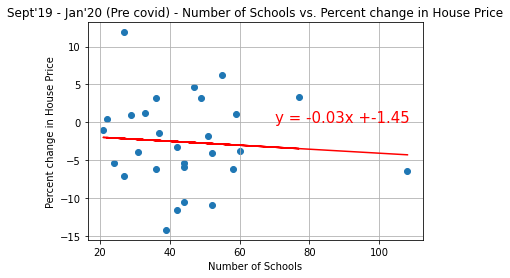

In [14]:
x_values = new_merged_lga_school["School Count"]
y_values = new_merged_lga_school["Percent change in house price"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Percent change in House Price", "Sept'19 - Jan'20", "Pre", (70,0), ylim=None)

The linear regression model above shows no correlation between the number of schools and the percent change in median house price. This means that the change in house prices/value in a particular LGA is not affected by the number of schools in that area. It is worth mentioning that most of the data points are clustered in the 20 to 60 schools per LGA

The r-squared is: 0.4010216691230963
The correlation between both factors is 0.63


[&lt;matplotlib.lines.Line2D at 0x227f3b58438&gt;]

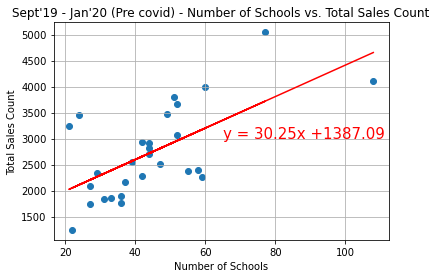

In [15]:
x_values = new_merged_lga_school["School Count"]
y_values = new_merged_lga_school["Total Sales"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Total Sales Count", "Sept'19 - Jan'20", "Pre", (65,3000), ylim=None)

The linear regression model above shows a moderate positive correlation between the number of schools and the total sales count. This means that the higher the number of schools in any given LGA, there is a considerably higher total sales count for that LGA. It is safe to assume that before COVID-19 there are a considerable number of buyers whose buying decisions are driven by the proximity of schools within their residence.

In [16]:
# Import victorian sales during covid
sales_covid_file = ("./Resources/vic-sales-postcovid.csv")
sales_covid_df = pd.read_csv(sales_covid_file)

In [17]:
# Retrieve just relevant columns
sales_covid_df = sales_covid_df[["LGA_Name", "price"]]

# Groupby LGA name
covid_grouped_sales = sales_covid_df.groupby(["LGA_Name"])

# Count number of sales
covid_grouped_sales = covid_grouped_sales["price"].count()

covid_grouped_sales = pd.DataFrame(covid_grouped_sales)

# Rename price to count
covid_grouped_sales = covid_grouped_sales.rename(columns={"price": "Sales Count"})
covid_grouped_sales.head()

,Sales Count
LGA_Name,
Banyule,609
Bayside,490
Boroondara,500
Brimbank,651
Cardinia,687


In [18]:
# Merge school count into covid sales count
covid_merged_lga_school_df = pd.merge(covid_grouped_sales, schools_count_df, on="LGA_Name")
covid_merged_lga_school_df.head()

,LGA_Name,Sales Count,School Count
0,Banyule,609,42
1,Bayside,490,27
2,Boroondara,500,58
3,Brimbank,651,59
4,Cardinia,687,37


In [19]:
# Removing outliers in data using z-score
# Only retrieve interested columns
covid_merged_lga_school = covid_merged_lga_school_df[["Sales Count", "School Count"]]

# Run zscore function
new_covid_merged_lga_school = zscore_function(covid_merged_lga_school, "new_covid_merged_lga_school")

# Adding LGA_Name column to new df
new_covid_merged_lga_school["LGA_Name"] = covid_merged_lga_school_df["LGA_Name"]

# Rearrange columns
new_covid_merged_lga_school = new_covid_merged_lga_school[["LGA_Name", "Sales Count", "School Count"]]
new_covid_merged_lga_school.head()

,LGA_Name,Sales Count,School Count
0,Banyule,609,42
1,Bayside,490,27
2,Boroondara,500,58
3,Brimbank,651,59
4,Cardinia,687,37


The r-squared is: 0.5134316588658595
The correlation between both factors is 0.72


[&lt;matplotlib.lines.Line2D at 0x227f3ba0a90&gt;]

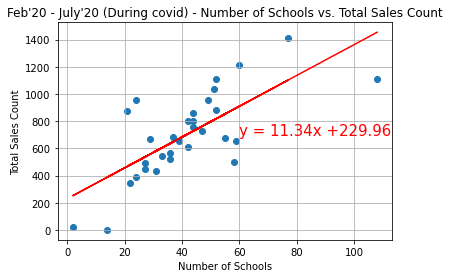

In [20]:
x_values = new_covid_merged_lga_school["School Count"]
y_values = new_covid_merged_lga_school["Sales Count"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Total Sales Count", "Feb'20 - July'20", "During", (60,700), ylim=None)

The linear regression model above shows a strong positive correlation between the number of schools and the total sales count. This means that the higher the number of schools in any given LGA, there is a higher total sales count for that LGA. It is safe to assume that even during COVID-19, buyers' house buying decisions are still affected by the proximity of schools within their residence.

By observing both linear regression charts of pre and during covid, we can say that regardless of the situation or circumstance, home buyers still place an importance in schools being close to their homes. As the number of schools go up, so does the total sales count. It is likely that a large proportion of home buyers make up of people with families, therefore their buying decisions may be contributed by the variety in school choices such as school education levels, government/private schools etc. 